In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

In [85]:
def primary_drag_force_components_base(mach_number):
	radial_component = 0.3 * (mach_number ** 2)
	azimuthal_component = np.log(10 / ((0.11 * mach_number) + 1.65))
	
	if mach_number < 6.2:
		radial_component = 4 + (mach_number ** 2) * (np.e ** -(mach_number - 7)) * np.sin( ((mach_number - 4.4) / 4)) / 5
	
	if 1.1 <= mach_number < 4.4:
		radial_component = 0.5 * np.log(9.33 * (mach_number ** 2) * (mach_number ** 2 - 0.95))
	if 1.0 <= mach_number < 4.4:
		azimuthal_component = np.log(3300 * ((mach_number - 0.71) ** 5.72) * (mach_number ** -9.58))
		
	if mach_number < 1.1:
		radial_component = (mach_number ** 2) * (10 ** ((3.51 * mach_number) - 4.22))	
	if mach_number < 1.0:
		azimuthal_component = 0.7706 * np.log((1 + mach_number) / (1.0004 - 0.9185 * mach_number)) - 1.4703 * mach_number
		
	if mach_number <= 0.0523352:
		azimuthal_component = 0.0
		
	return radial_component, azimuthal_component

primary_drag_force_components = np.vectorize(primary_drag_force_components_base)

def secondary_drag_force_components_base(mach_number):
	radial_component = 0.56 - (0.027 * (mach_number + ((mach_number - 6) ** -1)))
	azimuthal_component = -0.13 + 0.07 * np.arctan((5 * mach_number) - 15)
	
	if 2.97 <= mach_number < 6.2:
		radial_component = 0.76 - (0.08 * (mach_number + ((mach_number - 2.76) ** -1)))
		
	if mach_number < 2.97:
		radial_component = 0.5 - (0.43 * (1 - np.cosh(2.2 * mach_number) ** -0.36))
		azimuthal_component = -0.022 * (10 - mach_number) * np.tanh(3 * mach_number / 2)

	radial_component *= mach_number ** 2
	azimuthal_component *= mach_number ** 2

	return radial_component, azimuthal_component

secondary_drag_force_components = np.vectorize(secondary_drag_force_components_base)

In [86]:
mach = np.linspace(0, 8, 1000)

prime = primary_drag_force_components(mach)
second = secondary_drag_force_components(mach)

/tmp/ipykernel_7133/1787146342.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(mach, (prime[0] + second[0]) / mach ** 2, c='blue')
/tmp/ipykernel_7133/1787146342.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(mach, (prime[1] + second[1]) / mach ** 2, c='red')
/tmp/ipykernel_7133/1787146342.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(mach, prime[0] / mach ** 2, c='blue', linestyle="dashed")
/tmp/ipykernel_7133/1787146342.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(mach, second[0] / mach ** 2, c='blue', linestyle="dotted")
/tmp/ipykernel_7133/1787146342.py:7: RuntimeWarning: invalid value encountered in divide
  plt.plot(mach, prime[1] / mach ** 2, c='red', linestyle="dashed")
/tmp/ipykernel_7133/1787146342.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(mach, second[1] / mach ** 2, c='red', linestyle="dotted")


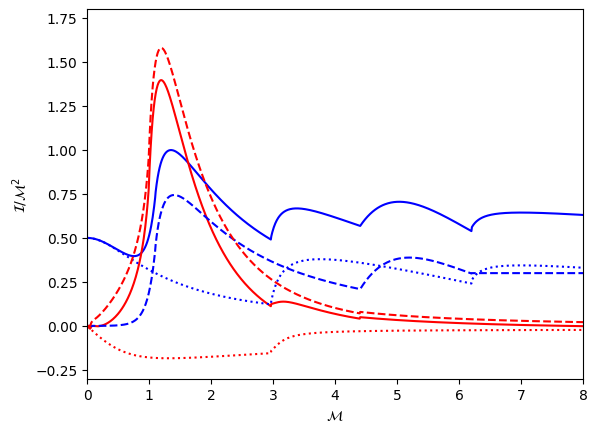

In [87]:
plt.plot(mach, (prime[0] + second[0]) / mach ** 2, c='blue')
plt.plot(mach, (prime[1] + second[1]) / mach ** 2, c='red')

plt.plot(mach, prime[0] / mach ** 2, c='blue', linestyle="dashed")
plt.plot(mach, second[0] / mach ** 2, c='blue', linestyle="dotted")

plt.plot(mach, prime[1] / mach ** 2, c='red', linestyle="dashed")
plt.plot(mach, second[1] / mach ** 2, c='red', linestyle="dotted")

plt.ylim((-0.3,1.8))
plt.xlim((0, 8))

plt.ylabel("$\mathcal{I}/\mathcal{M}^2$")
plt.xlabel("$\mathcal{M}$")

plt.savefig("bleh.png")

In [88]:
def drag_forces(mass, velocity, density, sound_speed, func_drag_force_components):
	mach_number = velocity / sound_speed
	drag_force_components = func_drag_force_components(mach_number.value)
	force_component = (4 * np.pi * density * (const.G * mass) ** 2 ) / velocity ** 2
	
	return (-force_component * drag_force_components[0]), (-force_component * drag_force_components[0])

In [89]:
m1 = 10 * const.M_sun.si
cs = (1e7 * (u.cm / u.s)).si # sg-disk @ ~200 rg
rho = (1e-14 * (u.g / u.cm ** 3)).si # sg-disk @ ~200 rg
v = (np.linspace(0, 8e7, 1000) * (u.cm / u.s) ).si

prime_df = drag_forces(m1, v, rho, cs, primary_drag_force_components)
secondary_df = drag_forces(m1, v, rho, cs, secondary_drag_force_components)

total_df = np.sqrt((prime_df[0] + secondary_df[0]) ** 2 + (prime_df[1] + secondary_df[1]) ** 2)

Text(0.5, 0, 'Mach Number ($V/c_s$)')

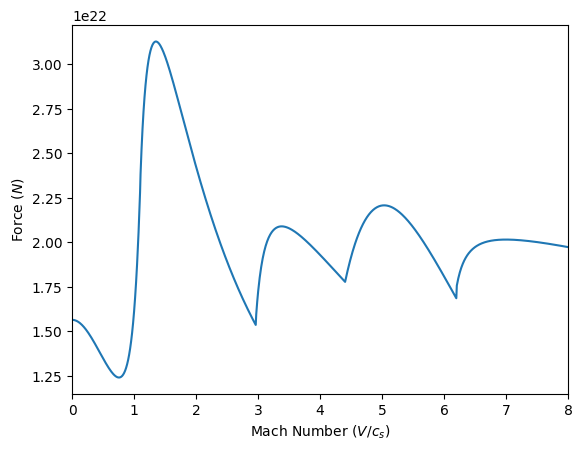

In [90]:
plt.plot(v/cs, total_df)
plt.xlim((0, 8))
plt.ylabel("Force ($N$)")
plt.xlabel("Mach Number ($V/c_s$)")
#plt.xlim((0, 0.2))

In [91]:
def change_in_separation(initial_separation, initial_velocity, drag_force, primary_mass, secondary_mass):
	return - (((initial_separation ** 2) * initial_velocity * (drag_force + drag_force)) / (const.G * primary_mass * secondary_mass))

In [92]:
primary_drag_force_components_base(0.0029744740711594715)

(5.460856683916689e-10, 0.0)

In [93]:
separations = []

binary_separation = 3e16 * u.m

for i in range(100000):
	orbital_velocity = np.sqrt((const.G * (m1 + m1)) / binary_separation)
	
	prime_df = drag_forces(m1, orbital_velocity, rho, cs, primary_drag_force_components)
	secondary_df = drag_forces(m1, orbital_velocity, rho, cs, secondary_drag_force_components)
	
	total_df = np.sqrt(prime_df[1] **2 + secondary_df[1] ** 2)
	
	delta_sep = change_in_separation(binary_separation, orbital_velocity, total_df, m1, m1)

	#print(f"{orbital_velocity}, {binary_separation}, {total_df}, {delta_sep}, {(delta_sep / const.c) * 100}")

	separations.append(binary_separation.value)

	binary_separation += (delta_sep * ((1000 * u.yr).to(u.s)))
	

Text(0.5, 0, 'Time [1 = 1000 yrs]')

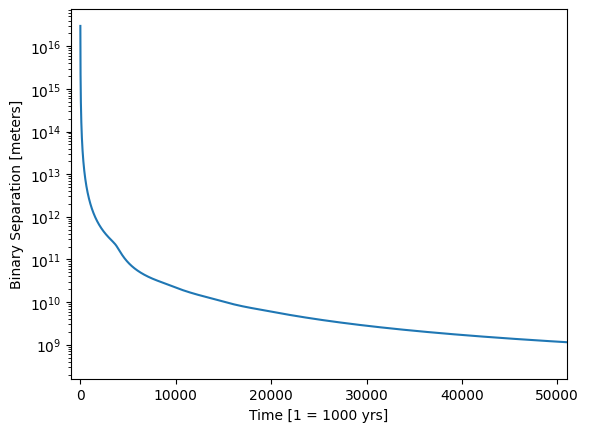

In [96]:
plt.plot(separations)
plt.yscale('log')
plt.xlim((-1000, 51000))
plt.ylabel("Binary Separation [meters]")
plt.xlabel("Time [1 = 1000 yrs]")